# Installing/Updating Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 16.0 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-16 18:16:09.686887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747419369.884825      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747419369.949413      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)

        # Filtering out examples without context
        if not record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        record_dict["prompts"] += f" \n\nContext: {record['context']}"
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

# Exploratory Data Analysis:

In [6]:
def plot():
    context_lengths = []
    response_lengths = []
    
    for i in range(len(data)):
        context_lengths.append(len(data[i]["prompts"].split("\n\nContext: ")[-1].split()))
        response_lengths.append(len(data[i]["responses"].split()))

    df = pd.DataFrame({"context lengths":context_lengths, "response lengths":response_lengths})
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250)
    sns.histplot(data=df, x="context lengths", bins=100, ax=axes[0], kde=True).set_title("Distribution of context lengths (number of words)")
    sns.histplot(data=df, x="response lengths", bins=100, ax=axes[1], kde=True).set_title("Distribution of response lengths (number of words")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

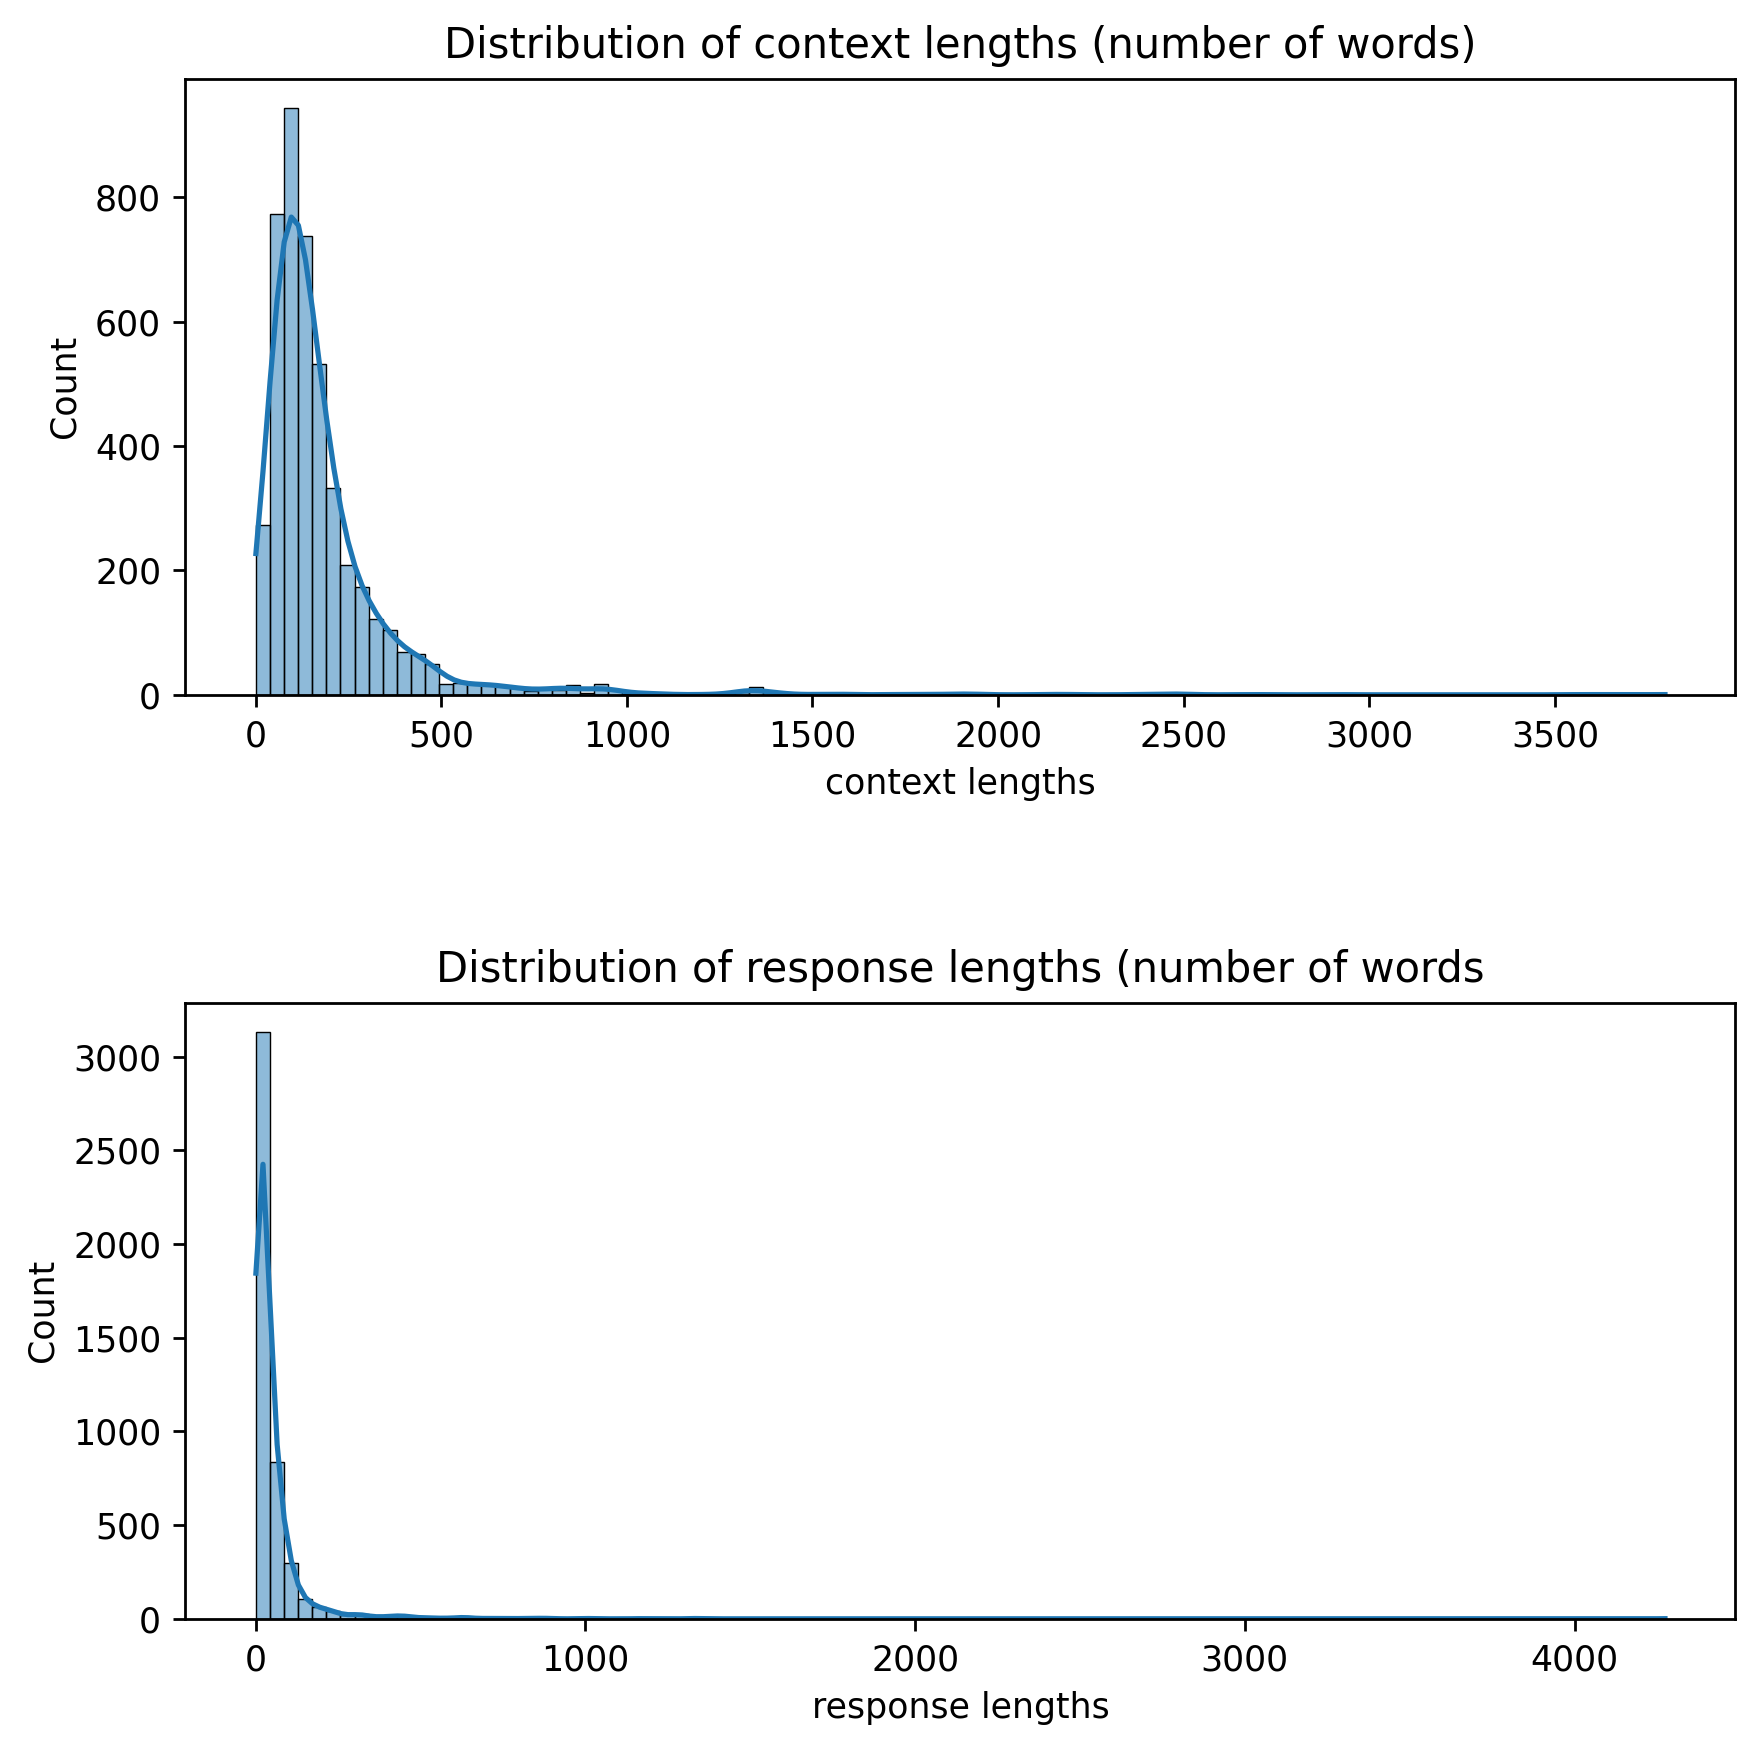

In [7]:
plot()

# Function for Coloring and Formatting the Texts:

In [8]:
def colorize_text(text):
    for word, color in zip(["Question: ", "Context: ", "Answer: ", "System: "], ["crimson", "cyan", "lightgreen", "aquamarine"]):
        text = text.replace(f"{word}", f"<font color='{color}' size='5'><strong>{word}</strong></font>")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Question: {value}\n\n"
        elif key == "responses":
            text += f"Answer: {value}\n\n"

    text = colorize_text(text)
    
    return text

In [9]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
text = f"<center><font color='Yellow' size='6'><strong>Example {n}:</strong></center></font>\n\n"
text += colorize_text_from_dict(data[n])
display(Markdown(text))

<center><font color='Yellow' size='6'><strong>Example 0:</strong></center></font>

<font color='crimson' size='5'><strong>Question: </strong></font>When did Virgin Australia start operating? 

<font color='cyan' size='5'><strong>Context: </strong></font>Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]

<font color='lightgreen' size='5'><strong>Answer: </strong></font>Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.



# Building TensorFlow Dataset:

In [10]:
random.shuffle(data) # Shuffling the list
dataset = data[:500] # Taking the first 500 examples for faster training
test_dataset = data[500:]

In [11]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [12]:
dataset = build_tf_dataset(dataset)

I0000 00:00:1747419386.619073      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [13]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [14]:
template = """System: 
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

Question: 
{question}

Context: 
{context}

Answer: \n\n
"""

In [15]:
def generate_inference(example_num=None):
    if example_num == None or example_num >= len(test_dataset):
        example_num = random.randint(0, len(test_dataset))

    example = test_dataset[example_num]
    question = example["prompts"].split("\n\nContext: ")[0]
    context = example["prompts"].split("\n\nContext: ")[-1]
    answer = example["responses"]

    input_prompt = template.format(question=question, context=context)
    max_length = 2 * len(input_prompt.split())
    response = gemma3_1b.generate(input_prompt, max_length=max_length)
    response = response.split("Answer: \n\n")[-1].strip()

    colored_text = f"<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number {example_num}:</strong></center></font>\n\n"
    colored_text += colorize_text(input_prompt)
    colored_text += f"<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>\n\n{answer}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>\n\n"
    colored_text += colorize_text(response)
    
    colored_text += f"{colorize_text(response)}"
    
    return colored_text

In [16]:
display(Markdown(generate_inference()))

I0000 00:00:1747419429.334795      19 service.cc:148] XLA service 0x1ebabef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747419429.335784      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747419436.007562      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747419447.827702      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 2929:</strong></center></font>

<font color='aquamarine' size='5'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='5'><strong>Question: </strong></font>
Tell me a few flaws of the Human Development Index from this passage 

<font color='cyan' size='5'><strong>Context: </strong></font>
The Human Development Index (HDI) is a statistic composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development. A country scores a higher level of HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. It was developed by Pakistani economist Mahbub ul Haq and was further used to measure a country's development by the United Nations Development Programme (UNDP)'s Human Development Report Office.

The 2010 Human Development Report introduced an Inequality-adjusted Human Development Index (IHDI). While the simple HDI remains useful, it stated that "the IHDI is the actual level of human development (accounting for inequality), while the HDI can be viewed as an index of 'potential' human development (or the maximum level of HDI) that could be achieved if there were no inequality."

The index is based on the human development approach, developed by Mahbub ul Haq, anchored in Amartya Sen's work on human capabilities, and often framed in terms of whether people are able to "be" and "do" desirable things in life. Examples include – being: well fed, sheltered, and healthy; doing: work, education, voting, participating in community life. The freedom of choice is central – someone choosing to be hungry (e.g. when fasting for religious reasons) is quite different from someone who is hungry because they cannot afford to buy food, or because the country is in a famine.

The index does not take into account several factors, such as the net wealth per capita or the relative quality of goods in a country. This situation tends to lower the ranking of some of the most developed countries, such as the G7 members and others.

<font color='lightgreen' size='5'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

Human Development Index has been revised in 2010 owing to a few limitations. HDI is believed to estimate the 'potential' human development that could be achieved if there were no inequality. The revised Inequality-adjusted Human Development Index (IHDI) is the actual level of human development (accounting for inequality). Secondly, HDI does not take into account several factors, such as the net wealth per capita or the relative quality of goods in a country. This situation tends to lower the ranking of some of the most developed countries, such as the G7 members and others.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The HDI is a composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development. A country scores a higher level of HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. It was developed by Pakistani economist Mahbub ul Haq and was further used to measure a country's development by the United Nations Development Programme (UNDP)'s Human Development Report Office.

The 2010 Human Development Report introduced an Inequality-adjusted Human Development Index (IHDI). While the simple HDI remains useful, it stated that "the IHDI is the actual level of human development (accounting for inequality), while the HDI can be viewed as an index of 'potential' human development (or the maximum level of HDI) that could be achieved if there were no inequality."

The index is based on the human development approach, developed by Mahbub ul Haq, anchored in Amartya Sen's work on human capabilities, and often framed in terms of whether people are able to "be" and "do" desirable things in life. Examples include – being: well fed, sheltered, and healthy; doing: work, education, voting, participating in community life. The freedom of choice is central – someone choosing to be hungry (e.g. when fasting forThe HDI is a composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development. A country scores a higher level of HDI when the lifespan is higher, the education level is higher, and the gross national income GNI (PPP) per capita is higher. It was developed by Pakistani economist Mahbub ul Haq and was further used to measure a country's development by the United Nations Development Programme (UNDP)'s Human Development Report Office.

The 2010 Human Development Report introduced an Inequality-adjusted Human Development Index (IHDI). While the simple HDI remains useful, it stated that "the IHDI is the actual level of human development (accounting for inequality), while the HDI can be viewed as an index of 'potential' human development (or the maximum level of HDI) that could be achieved if there were no inequality."

The index is based on the human development approach, developed by Mahbub ul Haq, anchored in Amartya Sen's work on human capabilities, and often framed in terms of whether people are able to "be" and "do" desirable things in life. Examples include – being: well fed, sheltered, and healthy; doing: work, education, voting, participating in community life. The freedom of choice is central – someone choosing to be hungry (e.g. when fasting for

In [17]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 534:</strong></center></font>

<font color='aquamarine' size='5'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='5'><strong>Question: </strong></font>
Which companies did Theranos partner with in 2015? 

<font color='cyan' size='5'><strong>Context: </strong></font>
In 2012 Safeway invested $350 million into retrofitting 800 locations with clinics that would offer in-store blood tests. After many missed deadlines and questionable results from a trial clinic at Safeway's corporate offices, the deal was terminated in 2015.[18] In 2013, Theranos partnered with Walgreens to offer in-store blood tests at more than 40 locations.[19] Although Theranos blood tests were reportedly used on drug trial patients for GlaxoSmithKline and Pfizer, both companies stated that there were no active projects with Theranos in October 2015.[20][21] In June 2016, Walgreens terminated its partnership with Theranos. In November 2016 it filed suit against Theranos in federal court in Delaware for breach of contract. In June 2017, Theranos reported to investors that the suit, which originally sought $140 million in damages, was settled for less than $30 million.[22][23]

In March 2015 the Cleveland Clinic announced a partnership with Theranos to test its technology and decrease the cost of lab tests.[24][25] In July 2015, Theranos became the lab-work provider for Pennsylvania insurers AmeriHealth Caritas and Capital Blue Cross.[26][27]

In July 2015 the Food and Drug Administration approved the use of the company's fingerstick blood testing device for the herpes simplex virus (HSV-1) outside a clinical laboratory setting.[28][29] Theranos was named the 2015 Bioscience Company of the Year by the Arizona BioIndustry Association (AzBio).[30]

<font color='lightgreen' size='5'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

Theranos partnered with Cleveland Clinic in March 2015 to test its technology and decrease the cost of lab tests. In July 2015, Theranos became the lab-work provider for Pennsylvania insurers AmeriHealth Caritas and Capital Blue Cross.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The answer to the question is: 
The answer cannot be found in the provided context.The answer to the question is: 
The answer cannot be found in the provided context.

# Fine-tuning with LoRA:

In [18]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [19]:
gemma3_1b.preprocessor.sequence_length = 1024

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [20]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [21]:
history = gemma3_1b.fit(dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747419570.224663      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 420s 629ms/step - loss: 0.0723 - sparse_categorical_accuracy: 0.7469
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.7489
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.7463
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.7254
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 628ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.7602
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.7496
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.7614
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0552 - sparse_categorical_accuracy: 0.7874
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.7807
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [22]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

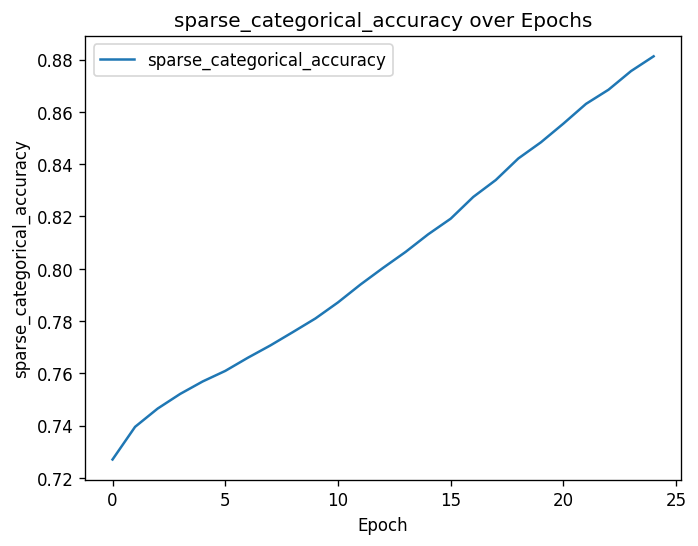

In [23]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [24]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 771:</strong></center></font>

<font color='aquamarine' size='5'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='5'><strong>Question: </strong></font>
Of the living animal species which have been described, which group has the most? 

<font color='cyan' size='5'><strong>Context: </strong></font>
Animals are multicellular, eukaryotic organisms in the biological kingdom Animalia. With few exceptions, animals consume organic material, breathe oxygen, are able to move, can reproduce sexually, and grow from a hollow sphere of cells, the blastula, during embryonic development. As of 2022, 2.16 million living animal species have been described—of which around 1.05 million are insects, over 36,000 are fishes, around 11,700 are reptiles, over 11,100 are birds, and 6,596 mammals—but it has been estimated there are around 7.77 million animal species in total. Animals range in length from 8.5 micrometres (0.00033 in) to 33.6 metres (110 ft). They have complex interactions with each other and their environments, forming intricate food webs. The scientific study of animals is known as zoology.

<font color='lightgreen' size='5'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

There are 1.05 million (1,050,000) insect species, which is the largest group in the animal kingdom.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

The living animal species which have been described, which group has the most is estimated to be 7.77 million animal species in total.The living animal species which have been described, which group has the most is estimated to be 7.77 million animal species in total.

In [25]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt for Example Number 1492:</strong></center></font>

<font color='aquamarine' size='5'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='5'><strong>Question: </strong></font>
What is feeding Springfield Reservoir? 

<font color='cyan' size='5'><strong>Context: </strong></font>
The Broad Brook Canal is a water-supply canal feeding the Springfield Reservoir (a.k.a. the Ludlow Reservoir) in Ludlow, Massachusetts, a public water supply for the city of Springfield, Massachusetts. Its northern segment is also known as the Jabish Canal.

The canal was first constructed circa 1875. It was 11,960 feet (3,650 m) in length, and fed the Springfield Reservoir at its eastern side with water collected in the Belchertown Reservoir and swamp. This water, however, was thought to be of poor quality, and thus in 1890–1891 the canal was extended north through the Belchertown Reservoir to Jabish Brook, east of Broad Brook. After this addition, the canal's total length was about 8 miles (13 km), of which 1,400 feet (430 m) ran through a cast-iron pipe (54 inches in diameter) across the Cherry Valley dam. The entire canal was worked to be 22 feet (6.7 m) wide at the surface, 8 feet (2.4 m) wide at the bottom, with a depth of 4.66 feet (1.42 m).

<font color='lightgreen' size='5'><strong>Answer: </strong></font>


<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></center></font>

The Broad Brook Canal is a water supply canal feeding the Springfield Reservoir also known as Ludlow Reservoir. It is the main water supply for the city of Springfield, Massachusetts. The Broad Brook canal was constructed in 1875 and is 11,960 feet in length.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></center></font>

What is feeding Springfield Reservoir?

The Broad Brook Canal is a water-supply canal feeding the Springfield Reservoir (a.k.a. the Ludlow Reservoir) in Ludlow, Massachusetts, a public water supply for the city of Springfield, Massachusetts, a public water supply for the city of Springfield, Massachusetts, a public water supply for the city of Springfield, MassachusettsWhat is feeding Springfield Reservoir?

The Broad Brook Canal is a water-supply canal feeding the Springfield Reservoir (a.k.a. the Ludlow Reservoir) in Ludlow, Massachusetts, a public water supply for the city of Springfield, Massachusetts, a public water supply for the city of Springfield, Massachusetts, a public water supply for the city of Springfield, Massachusetts